### Importing the necessary libraries

In [1]:
!pip -q install gymnasium

In [2]:

import gymnasium as gym
import numpy as np
import seaborn
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


### Helper functions

In [3]:
def egreedy(q_values, state, epsilon, num_actions):
  '''
  Epsilon greedy

  Parameters:
  q_values(numpy array): Q table
  state(int): current state
  epsilon(float): parameter in epsilon greedy
  num_actions(int): number of actions to choose from, action range from [0, num_actions)
  '''
  if np.random.rand() < epsilon:
      return np.random.choice(range(num_actions))
  else:
      return np.argmax(q_values[state, :])

In [4]:
def go2colour(option, env, state, optionQ, epsilon):
  '''
  Returns the action taken following an option and policy, along with a bool for option exit condition

  Parameters:

  option(int): [0, 3] choose which color the option is for, 0 - Red, 1 - Green, 2 - Yellow, 3 - Blue
  env: RL environment
  state(int): [0, 500] encrypted way which contains location of taxi, passenger and destination location, REF-taxiv3 doc
  optionQ(numpy array): Q table
  epsilon(float): epsilon used for following epsilon greedy approach

  Returns:
  optact(int): Action to be taken
  optdone(bool): Check if option exit conditions are met
  '''
  optdone = False
  colourLocs = env.unwrapped.locs
  state_x, state_y, p, _ = env.decode(state)

  if np.random.rand() < epsilon:
      optact = np.random.choice(optionQ.shape[2])
  else:
      optact = np.argmax(optionQ[state_x, state_y, :])
  if (state_x, state_y) == colourLocs[option]:
    optdone = True
    # optact = np.random.choice(optionQ.shape[2])
  return [optact, optdone]


In [5]:
def pickordrop(option, env, state, optionQ, epsilon):
  '''
  Returns the action taken following an option and policy, along with a bool for option exit condition

  Parameters:

  option(int): [0, 1] choose whether the option is on the pickup path or drop path, 0 - pickup , 1 - drop
  state(int): [0, 500] encrypted way which contains location of taxi, passenger and destination location, REF-taxiv3 doc
  optionQ(numpy array): Q table
  epsilon(float): epsilon used for following epsilon greedy approach

  Returns:
  optact(int): Action to be taken
  optdone(bool): Check if option exit conditions are met
  '''
  optdone = False
  colourLocs = env.unwrapped.locs
  state_x, state_y, p, d = env.decode(state)
  if np.random.rand() < epsilon:
      optact = np.random.choice(optionQ.shape[2])
  else:
      if option:
        optact = np.argmax(optionQ[d][state_x, state_y, :]) #if dropping option, Q table has destination as one of its column
      elif option == 0 and p != 4:
        optact = np.argmax(optionQ[p][state_x, state_y, :]) #if picking up option, Q table has passenger as one of its column
      else:
        optact = np.random.choice(optionQ.shape[2]) #edge case, pickup already completed, about to exit pickup option
  if p == 4 and option == 0:
    optdone = True
  if p != 4 and option == 1:
    optdone = True
  return [optact, optdone]

In [6]:
def plot_rewards(rewards, n_episodes = 5000, title = 'Reward Curves'):
  '''
  Function to plot rewards
  Parameters:
  rewards(list): Array of rewards
  n_episodes(int): number of episodes
  title(str): title
  '''
  fig, ax = plt.subplots(figsize=(10, 6))
  mean_scores = np.mean(rewards, axis=0)
  var_scores = np.var(rewards, axis=0)
  episodes = range(1, n_episodes + 1)
  ax.plot(episodes, mean_scores, color = 'red')
  ax.fill_between(episodes, mean_scores - np.sqrt(var_scores), mean_scores + np.sqrt(var_scores), alpha=0.4, color = 'orange')
  ax.set_xlabel('Episode')
  ax.set_ylabel('Reward')
  plt.title(title)
  plt.show()

In [7]:
SOUTH, NORTH, WEST, EAST = 0, 1, 2, 3
actions = [SOUTH, NORTH, EAST, WEST]
def plot_Q(Q, message = "Q plot"):
    '''
    Function to plot the direction chosen through Q table at each (x, y)
    Parameters:
    Q(numpy array): Q table
    '''
    plt.figure(figsize=(10,10))
    plt.title(message)
    colors = {' ': 'white',  # Empty cell
              'R': 'red',
              'G': 'green',
              'Y': 'yellow',
              'B': 'blue'}  # Wall or out-of-bounds

    # Define the state grid
    grid = np.array([
    [' ', ' ', ' ', ' ', ' '],
    [' ', ' ', ' ', ' ', ' '],
    [' ', ' ', ' ', ' ', ' '],
    [' ', ' ', ' ', ' ', ' '],
    [' ', ' ', ' ', ' ', ' ']
])
    colored =  env.unwrapped.locs
    grid[colored[0][1], 4-1*colored[0][0]] = 'R'
    grid[colored[1][1], 4-1*colored[1][0]] = 'G'
    grid[colored[2][1], 4-1*colored[2][0]] = 'Y'
    grid[colored[3][1], 4-1*colored[3][0]] = 'B'
    for i in range(len(grid)):
        for j in range(len(grid[i])):
            plt.gca().add_patch(plt.Rectangle((i, j), 1, 1, color=colors[grid[i, j]]))

    def x_direct(a):
        if a in [SOUTH, NORTH]:
            return 0
        return 1 if a == WEST else -1
    def y_direct(a):
        if a in [EAST, WEST]:
            return 0
        return 1 if a == NORTH else -1
    policy = Q.argmax(-1)
    policyx = np.vectorize(x_direct)(policy)
    policyy = np.vectorize(y_direct)(policy)
    idx = np.indices(policy.shape)
    plt.quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policyx.ravel(), policyy.ravel(), pivot="middle", color='black')
    plt.show()

In [8]:
def plot_Qoption(Q, env, p, d, title = 'smdp option'):
  '''
    Function to plot the option chosen through Q table at each (x, y) given passenger and destination
    Parameters:
    Q(numpy array): Q table
    env: RL environment
    p(int): passenger information
    d(int): destination information
  '''
  grid_points = [(x, y) for x in range(5) for y in range(5)]
  states = [env.encode(x, y, p, d) for (x, y) in grid_points]
  action_names = ['RED', 'GREEN', 'YELLOW', 'BLUE', 'PICK UP', 'DROP']
  actions = [action_names[Q.argmax(-1)[state]] for state in states]
  plt.figure(figsize=(10,10))
  colors = {' ': 'white', # Empty cell
              'R': 'red',
              'G': 'green',
              'Y': 'yellow',
              'B': 'blue'}  # Wall or out-of-bounds

    # Define the state grid
  grid = np.array([
    [' ', ' ', ' ', ' ', ' '],
    [' ', ' ', ' ', ' ', ' '],
    [' ', ' ', ' ', ' ', ' '],
    [' ', ' ', ' ', ' ', ' '],
    [' ', ' ', ' ', ' ', ' ']
])
  color2letter = {0 : 'R', 1 : 'G', 2 : 'Y', 3 : 'B'}
  colored =  env.unwrapped.locs
  if p < 4:
    grid[colored[p][1], colored[p][0]] = color2letter[p]
  grid[colored[d][1], colored[d][0]] = color2letter[d]
  for i in range(len(grid)):
        for j in range(len(grid[i])):
            plt.gca().add_patch(plt.Rectangle((i, j), 1, 1, color=colors[grid[i, j]]))

  plt.xlim(0, 5)
  plt.ylim(5, 0)
  plt.grid(True)
  plt.xticks(np.arange(0, 6, 1.0))
  plt.yticks(np.arange(0, 6, 1.0))
  plt.title(title)

  # create tuples of positions
  positions = [(x+0.25, y+0.25) for x in range(5) for y in range(5)]

  # add text
  for i, (x, y) in enumerate(grid_points):
      plt.text(y+0.25, x+0.25, f'{actions[i]}', color='black')
  plt.show()





In [9]:
def plot_Qoption_alt(Q, env, p, d, title = 'smdp option'):
  '''
    Function to plot the option chosen through Q table at each (x, y) given passenger and destination
    Parameters:
    Q(numpy array): Q table
    env: RL environment
    p(int): passenger information
    d(int): destination information
  '''
  grid_points = [(x, y) for x in range(5) for y in range(5)]
  states = [env.encode(x, y, p, d) for (x, y) in grid_points]
  action_names = ['PICKUP', 'DROP']
  actions = [action_names[Q.argmax(-1)[state]] for state in states]
  plt.figure(figsize=(10,10))
  colors = {' ': 'white', # Empty cell
              'R': 'red',
              'G': 'green',
              'Y': 'yellow',
              'B': 'blue'}  # Wall or out-of-bounds

    # Define the state grid
  grid = np.array([
    [' ', ' ', ' ', ' ', ' '],
    [' ', ' ', ' ', ' ', ' '],
    [' ', ' ', ' ', ' ', ' '],
    [' ', ' ', ' ', ' ', ' '],
    [' ', ' ', ' ', ' ', ' ']
])
  color2letter = {0 : 'R', 1 : 'G', 2 : 'Y', 3 : 'B'}
  colored =  env.unwrapped.locs
  if p < 4:
    grid[colored[p][1], colored[p][0]] = color2letter[p]
  grid[colored[d][1], colored[d][0]] = color2letter[d]
  for i in range(len(grid)):
        for j in range(len(grid[i])):
            plt.gca().add_patch(plt.Rectangle((i, j), 1, 1, color=colors[grid[i, j]]))

  plt.xlim(0, 5)
  plt.ylim(5, 0)
  plt.grid(True)
  plt.xticks(np.arange(0, 6, 1.0))
  plt.yticks(np.arange(0, 6, 1.0))
  plt.title(title)

  # create tuples of positions
  positions = [(x+0.25, y+0.25) for x in range(5) for y in range(5)]

  # add text
  for i, (x, y) in enumerate(grid_points):
      plt.text(y+0.25, x+0.25, f'{actions[i]}', color='black')
  plt.show()


### Initialize the environment

In [10]:
env = gym.make('Taxi-v3')
env.reset()

(332, {'prob': 1.0, 'action_mask': array([1, 1, 1, 0, 0, 0], dtype=int8)})

## SMDP

In [11]:
# Initialize parameters

episodes = 2000
num_runs = 5
gamma = 0.9
alpha = 0.05
initial_epsilon = 0.1
final_epsilon = 0.001
epsilon_decay = 0.9995

# Initialize the reward curve

reward_curves_SMDP = []

for _ in range(num_runs):

  # Initialize Q tables

  q_values_SMDP = np.zeros((500,6))
  q_values_options_SMDP = np.zeros((4,5,5,4))
  reward_curve = []
  for episode in tqdm(range(episodes)):
      state_t = env.reset()
      done = False
      state = state_t[0]
      episode_reward = 0
      epsilon = max(final_epsilon, initial_epsilon * (epsilon_decay ** episode))

      while not done:
          # Choose action
          action = egreedy(q_values_SMDP, state, epsilon, q_values_SMDP.shape[1])

          if action > 3:
              # Perform regular Q-Learning update for state-action pair
              next_state, reward, done, _, _ = env.step(action)
              q_values_SMDP[state, action] += alpha*(reward + extra_reward + gamma*max(q_values_SMDP[next_state,:]) - q_values_SMDP[state, action])
              state = next_state
              episode_reward += reward

          else:
              option = action
              reward_bar = 0
              state_t = state
              steps = 0
              optdone = False
              while (optdone == False and done == False):
                  # Continue inside an option
                  optact, optdone = go2colour(option, env, state, q_values_options_SMDP[option], epsilon)
                  if optdone:
                      #if option is complete, choose the next option before acting
                      continue
                  next_state, reward, done, _, _ = env.step(optact)
                  state_x, state_y, _, _ = env.decode(state)
                  next_state_x, next_state_y, _, _ = env.decode(next_state)
                  # Q table update for each option
                  q_values_options_SMDP[option][state_x][state_y][optact] += alpha*(reward + gamma*np.max(q_values_options_SMDP[option][next_state_x][next_state_y]) - q_values_options_SMDP[option][state_x][state_y][optact])
                  reward_bar = gamma*reward_bar + reward
                  state = next_state
                  steps += 1

              # One step SMDP Q table update for options
              q_values_SMDP[state_t, action] += alpha*(reward_bar + (gamma**steps)*np.max(q_values_SMDP[state,:]) - q_values_SMDP[state_t,action])
              episode_reward += reward_bar

      # Append the episode reward to the reward curve
      reward_curve.append(episode_reward)
  reward_curves_SMDP.append(reward_curve)


100%|██████████| 2000/2000 [00:30<00:00, 64.70it/s] 


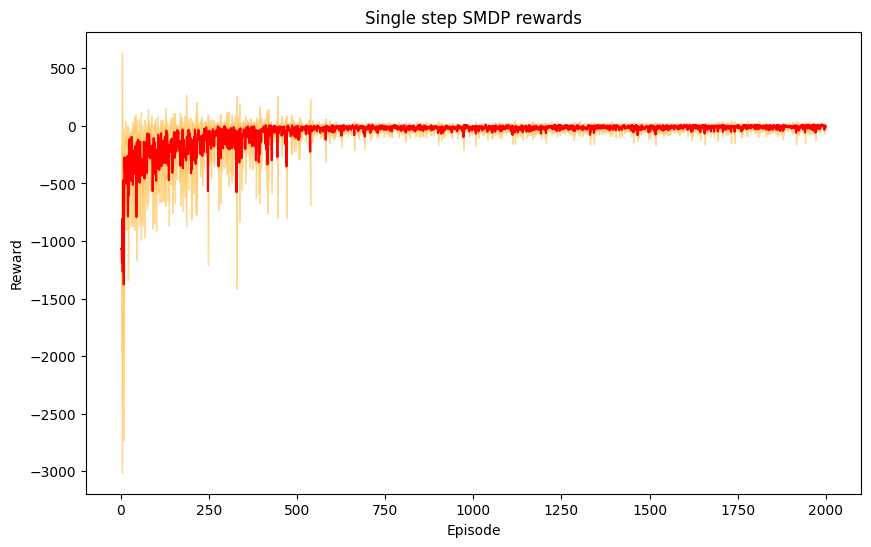

In [12]:
plot_rewards(reward_curves_SMDP, 2000, 'Single step SMDP rewards')

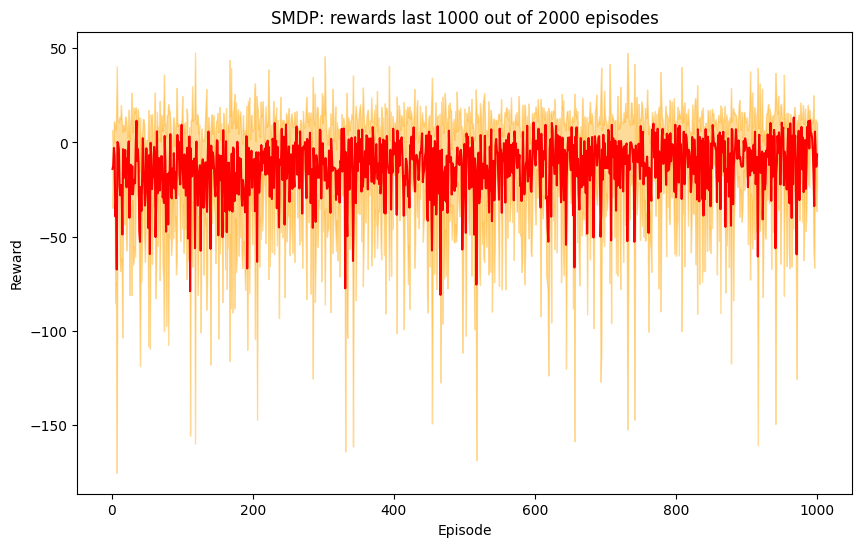

In [13]:
reward_curves_SMDP = np.asarray(reward_curves_SMDP)
plot_rewards(reward_curves_SMDP[:, -1000:], 1000, 'SMDP: rewards last 1000 out of 2000 episodes')

Quantitative visualization metrics

In [14]:
np.mean(reward_curves_SMDP)

-53.66605054929468

In [15]:
max(reward_curves_SMDP[0])

15.561

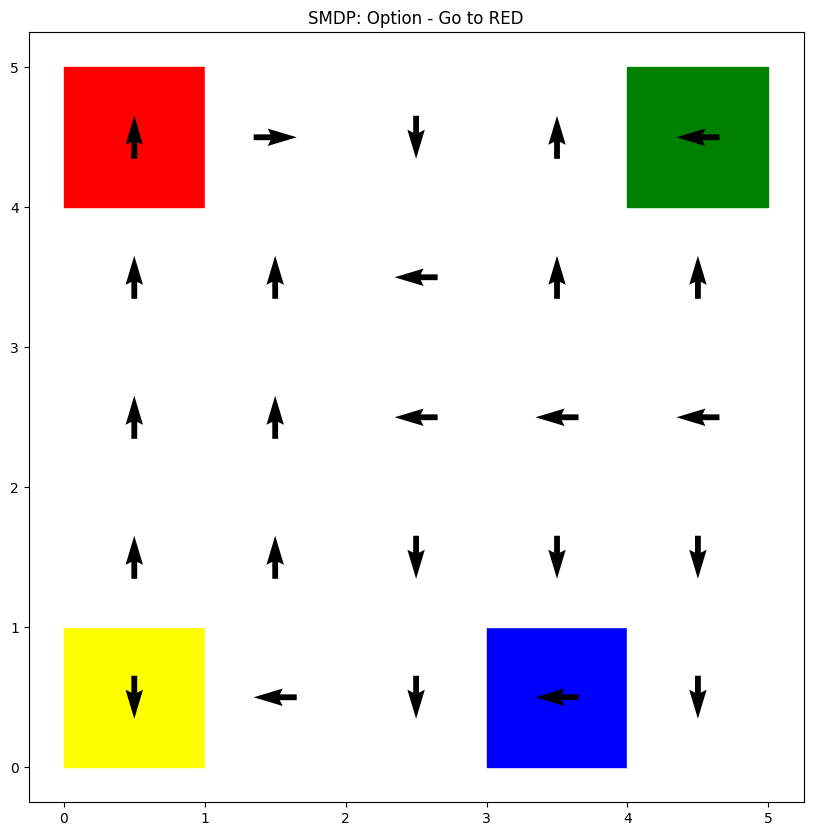

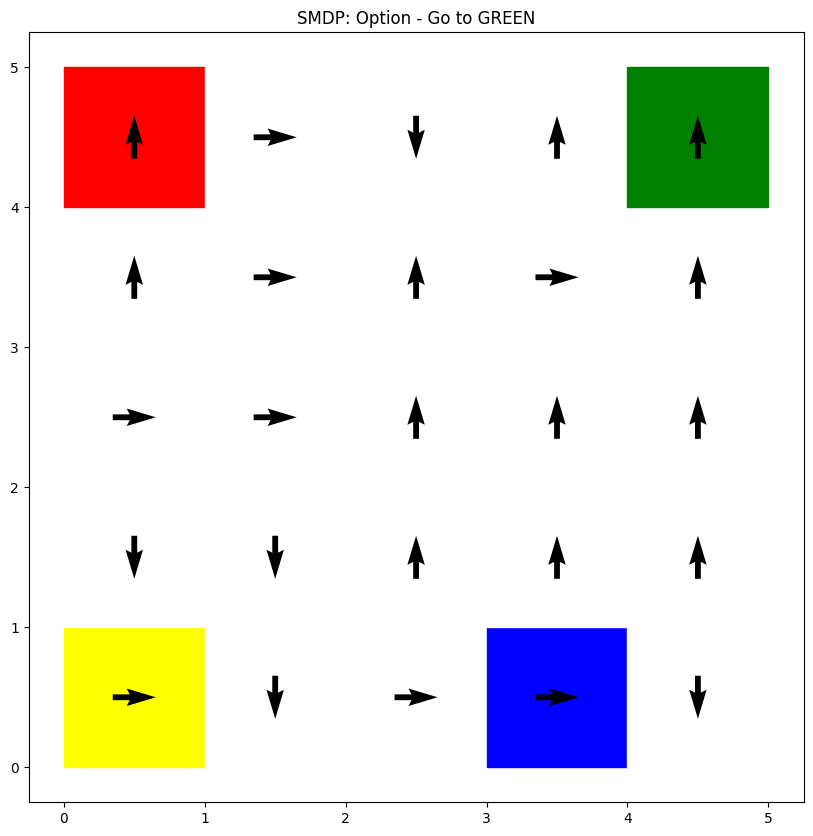

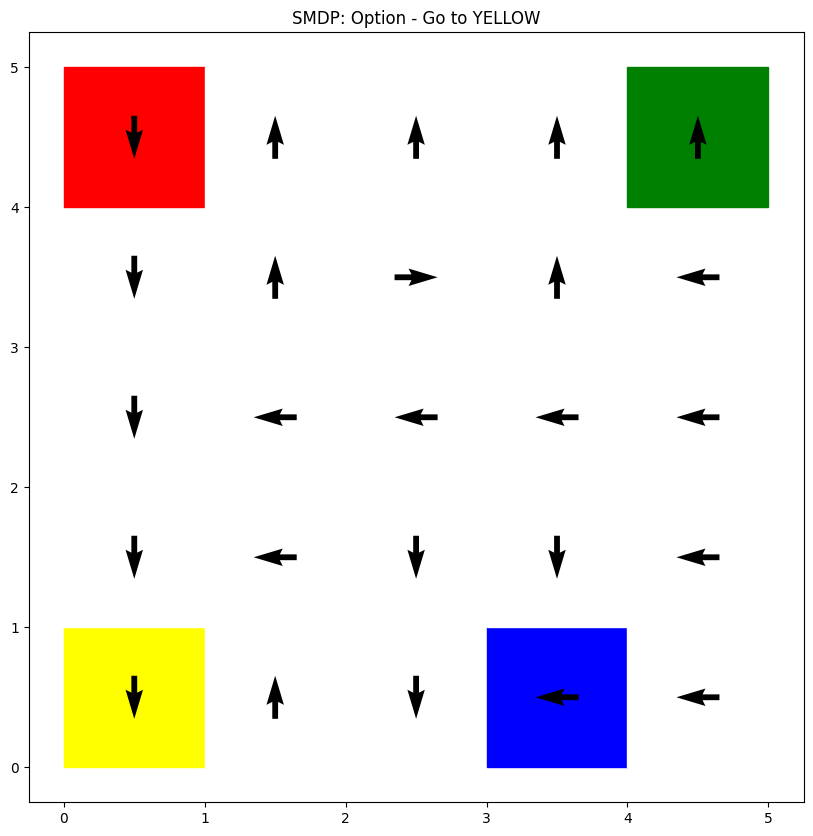

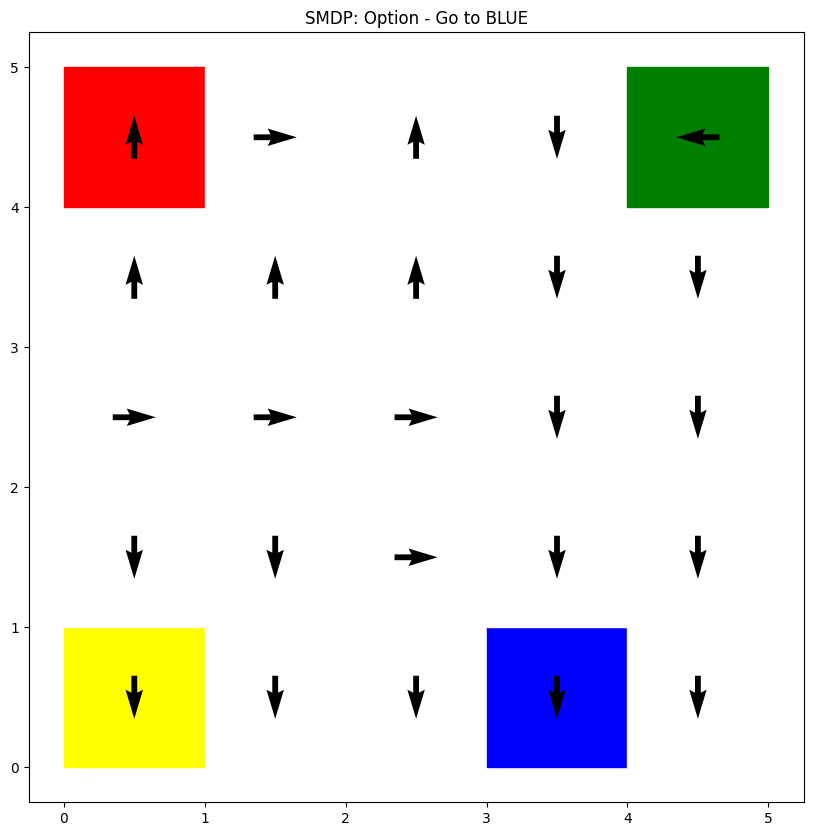

In [16]:
plot_Q(q_values_options_SMDP[0], "SMDP: Option - Go to RED")
plot_Q(q_values_options_SMDP[1], "SMDP: Option - Go to GREEN")
plot_Q(q_values_options_SMDP[2], "SMDP: Option - Go to YELLOW")
plot_Q(q_values_options_SMDP[3], "SMDP: Option - Go to BLUE")

In [17]:
q_values_SMDP.argmax(-1).shape

(500,)

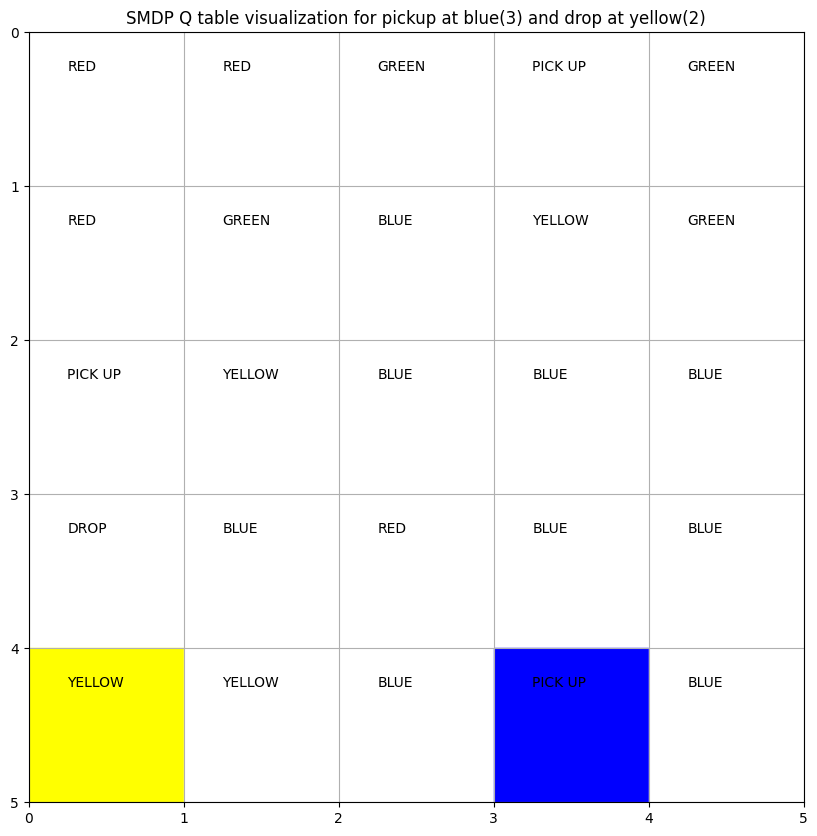

In [18]:
plot_Qoption(q_values_SMDP, env, 3, 2, 'SMDP Q table visualization for pickup at blue(3) and drop at yellow(2)')

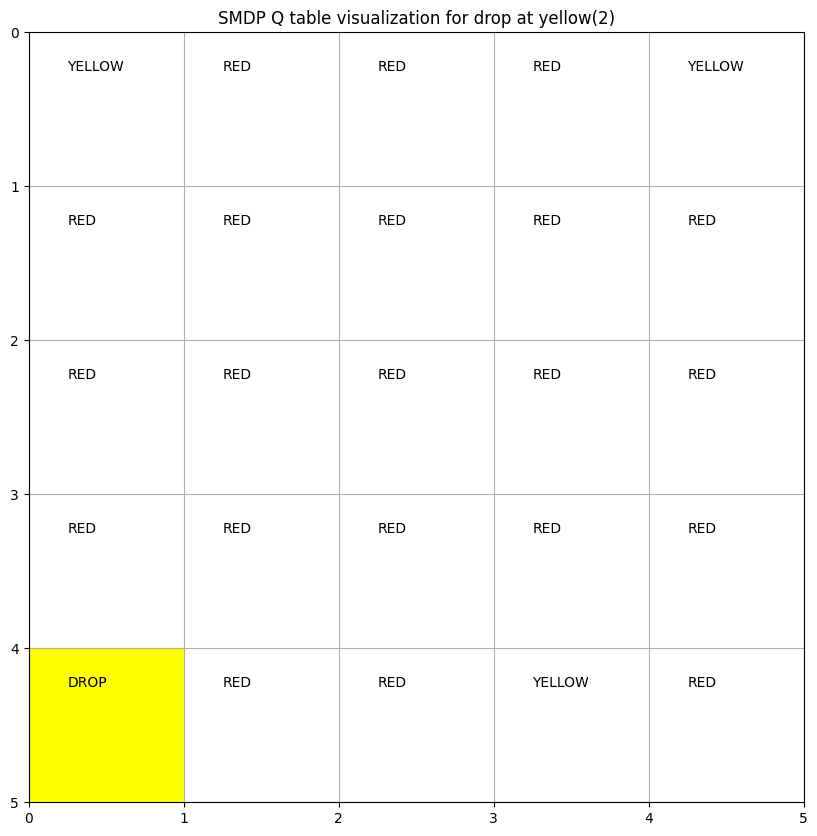

In [19]:
plot_Qoption(q_values_SMDP, env, 4, 2, 'SMDP Q table visualization for drop at yellow(2)')

## Intra Option Q learning

In [20]:
# Initialize parameters
episodes = 2000
num_runs = 5
gamma = 0.9
alpha = 0.05
initial_epsilon = 0.1
final_epsilon = 0.001
epsilon_decay = 0.9995
reward_curves_intra = []
# Helper functions for IOQL
def check_option(env, state, action, epsilon):
    '''
    Checks if the given action is valid for any option in the current state.

    Parameters:
        env: RL environment.
        state: current state.
        action: action to be checked.
        epsilon: epsilon value for epsilon-greedy action selection.

    Returns:
        valid_options: A list of indices representing options for which the action is valid.
    '''
    valid_options = []
    for i in range(4):
      optact, _ = go2colour(i, env, state, q_values_options_intra[i], epsilon)
      if optact == action:
        valid_options = valid_options + [i]
    return valid_options

def terminate_option(env, state, option, epsilon):
    '''
    Checks if the given option terminates in the current state.

    Parameters:
        env: RL environment.
        state: current state.
        option: option to be checked for termination.
        epsilon: epsilon value for epsilon-greedy action selection.

    Returns:
        optdone: Boolean value indicating whether the option terminates in the current state.
    '''
    if option < 4:
      _, optdone = go2colour(option, env, state, q_values_options_intra[option], epsilon)
      return optdone
    else:
      return True
for _ in range(num_runs):
  # Initialize the reward curve
  reward_curve = []

  q_values_intra = np.zeros((500,6))
  q_values_options_intra = np.zeros((4,5,5,4))
  for episode in tqdm(range(episodes)):
      state_t = env.reset()
      done = False
      state = state_t[0]
      episode_reward = 0
      epsilon = max(final_epsilon, initial_epsilon * (epsilon_decay ** episode))

      while not done:
          # Choose action
          action = egreedy(q_values_intra, state, epsilon, q_values_intra.shape[1])

          if action > 3:
              # Perform regular Q-Learning update for state-action pair
              next_state, reward, done, _, _ = env.step(action)
              # Conventional one-step Q-Learning update
              q_values_intra[state, action] += alpha*(reward + gamma*max(q_values_intra[next_state,:]) - q_values_intra[state, action])
              state = next_state
              episode_reward += reward

          else:
              # option = action - 6
              option = action
              reward_bar = 0
              state_t = state
              steps = 0
              optdone = False
              while (optdone == False and done == False):
                  optact, optdone = go2colour(option, env, state, q_values_options_intra[option], epsilon)
                  if optdone:
                      continue
                  next_state, reward, done, _, _ = env.step(optact)
                  state_x, state_y, _, _ = env.decode(state)
                  next_state_x, next_state_y, _, _ = env.decode(next_state)

                  q_values_options_intra[option][state_x][state_y][optact] += alpha*(reward + gamma*np.max(q_values_options_intra[option][next_state_x][next_state_y]) - q_values_options_intra[option][state_x][state_y][optact])

                  reward_bar = gamma*reward_bar + reward
                  state = next_state
                  steps += 1

                  matching_options = check_option(env, state, optact, epsilon)

                  # One-step intra-option Q-Learning update for all options with the same action
                  for o in matching_options:
                      beta = terminate_option(env, state, o, epsilon)
                      Q_tilde = (1-beta)*q_values_intra[next_state, o] + beta*(max(q_values_intra[next_state, :]))
                      q_values_intra[next_state, o] += alpha*(reward + gamma*Q_tilde - q_values_intra[next_state,o])


              q_values_intra[state_t, action] += alpha*(reward_bar + (gamma**steps)*np.max(q_values_intra[state,:]) - q_values_intra[state_t,action])
              episode_reward += reward_bar

      # Append the episode reward to the reward curve
      reward_curve.append(episode_reward)
  reward_curves_intra.append(reward_curve)


100%|██████████| 2000/2000 [00:46<00:00, 43.40it/s] 


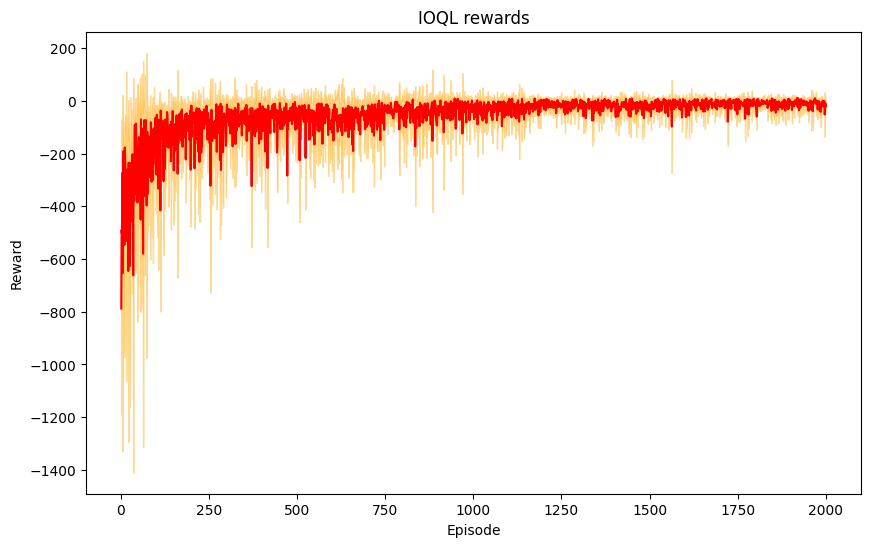

In [21]:
plot_rewards(reward_curves_intra, episodes, 'IOQL rewards')

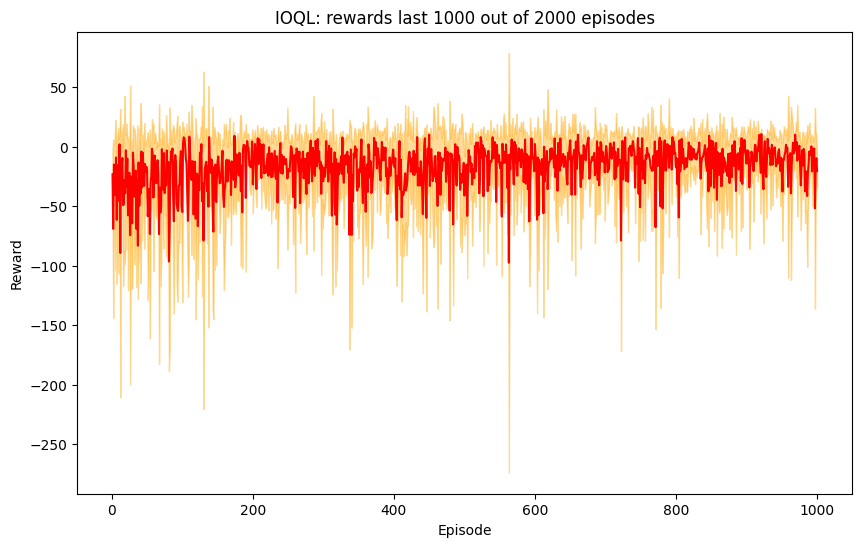

In [22]:
reward_curves_intra = np.asarray(reward_curves_intra)
plot_rewards(reward_curves_intra[:, -1000:], 1000, 'IOQL: rewards last 1000 out of 2000 episodes')

In [23]:
np.mean(reward_curves_intra)

-52.95835144366714

In [24]:
max(reward_curves_intra[0])

15.561

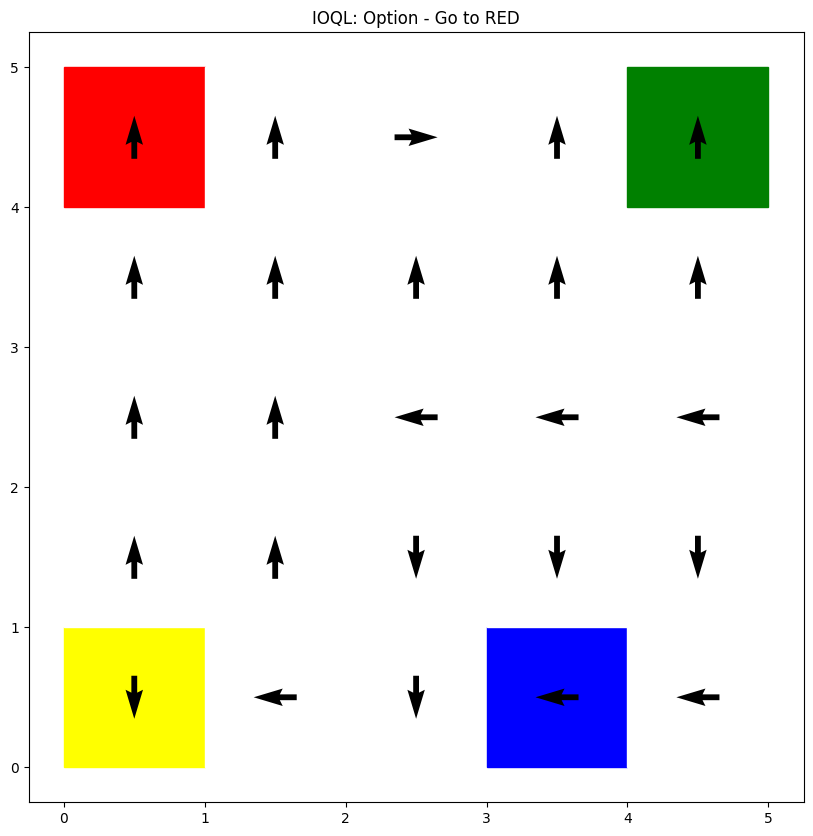

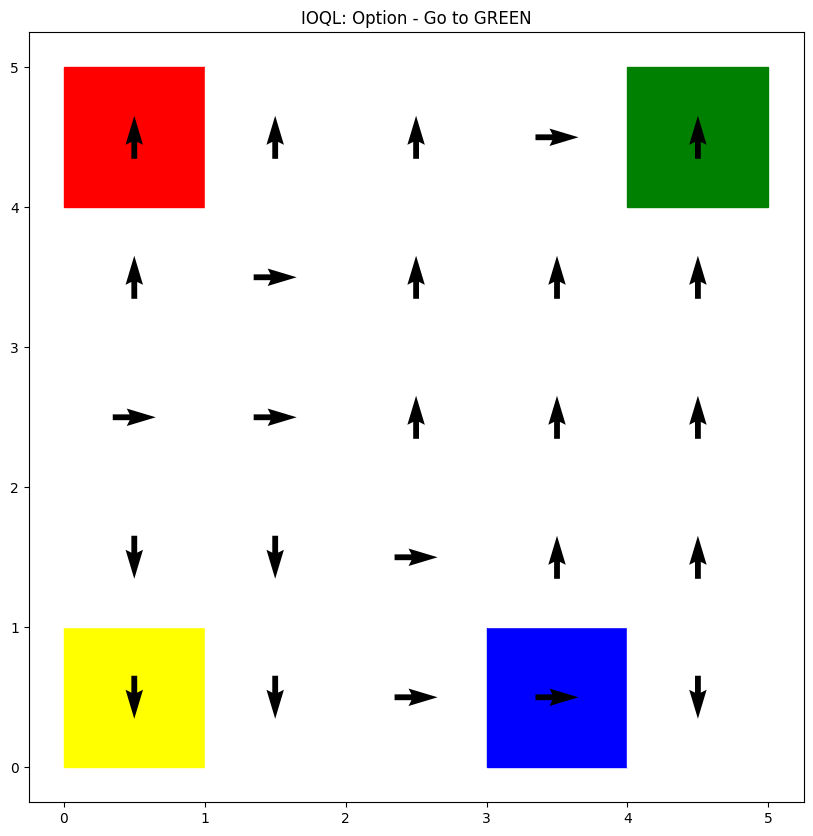

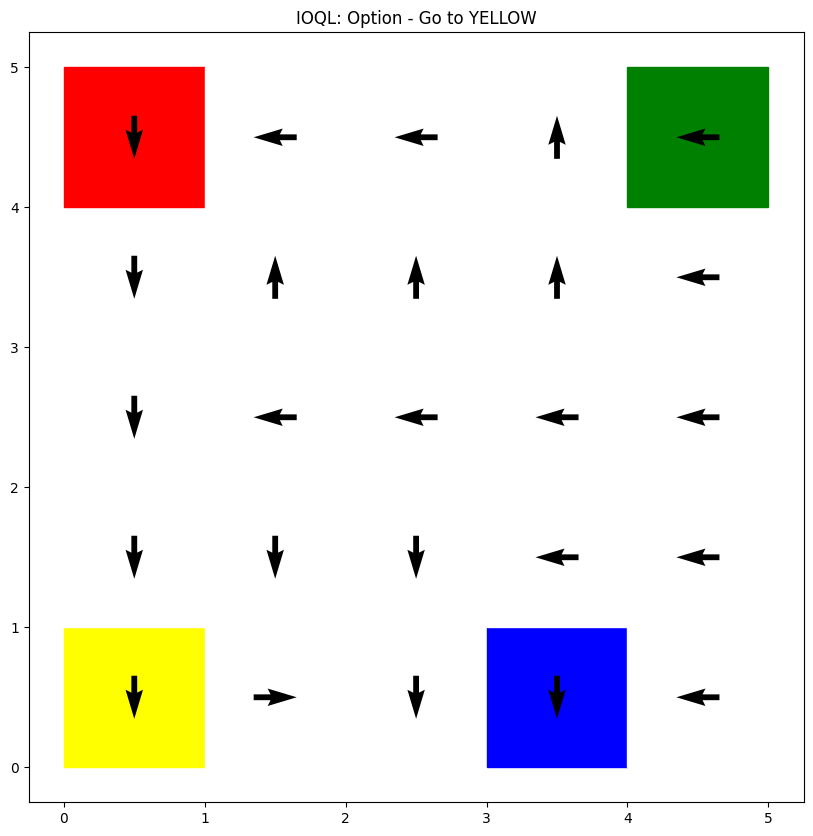

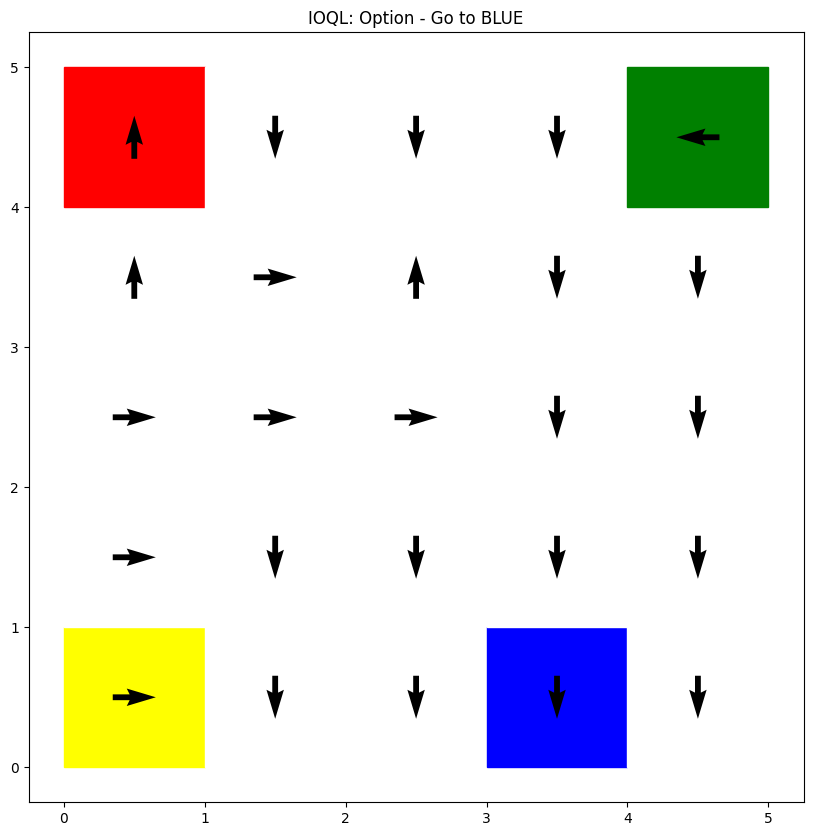

In [25]:
plot_Q(q_values_options_intra[0], "IOQL: Option - Go to RED")
plot_Q(q_values_options_intra[1], "IOQL: Option - Go to GREEN")
plot_Q(q_values_options_intra[2], "IOQL: Option - Go to YELLOW")
plot_Q(q_values_options_intra[3], "IOQL: Option - Go to BLUE")

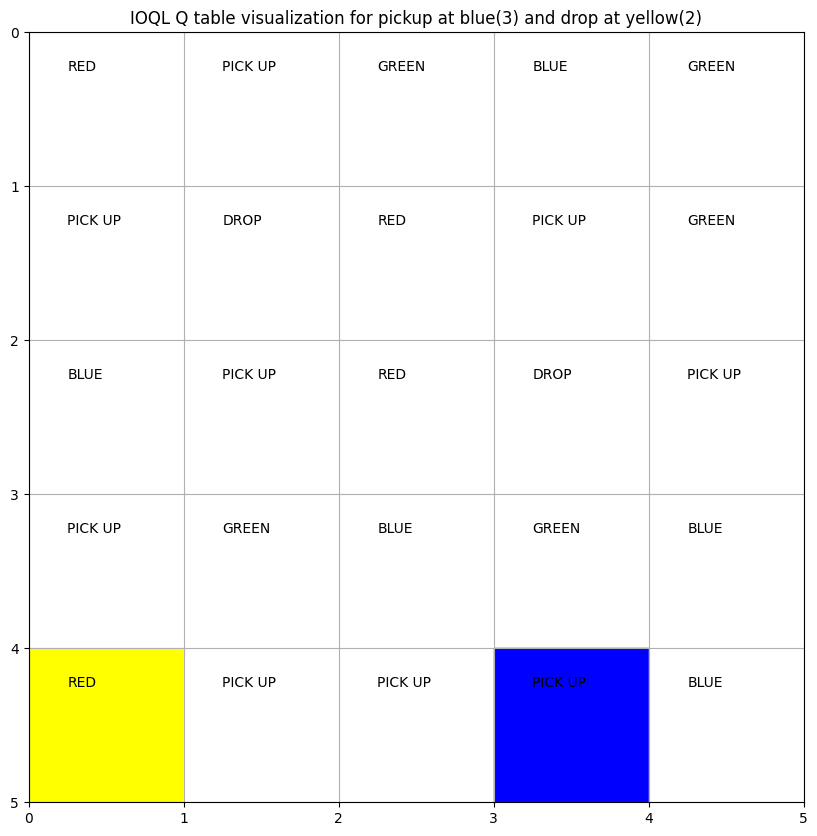

In [26]:
plot_Qoption(q_values_intra, env, 3, 2, 'IOQL Q table visualization for pickup at blue(3) and drop at yellow(2)')

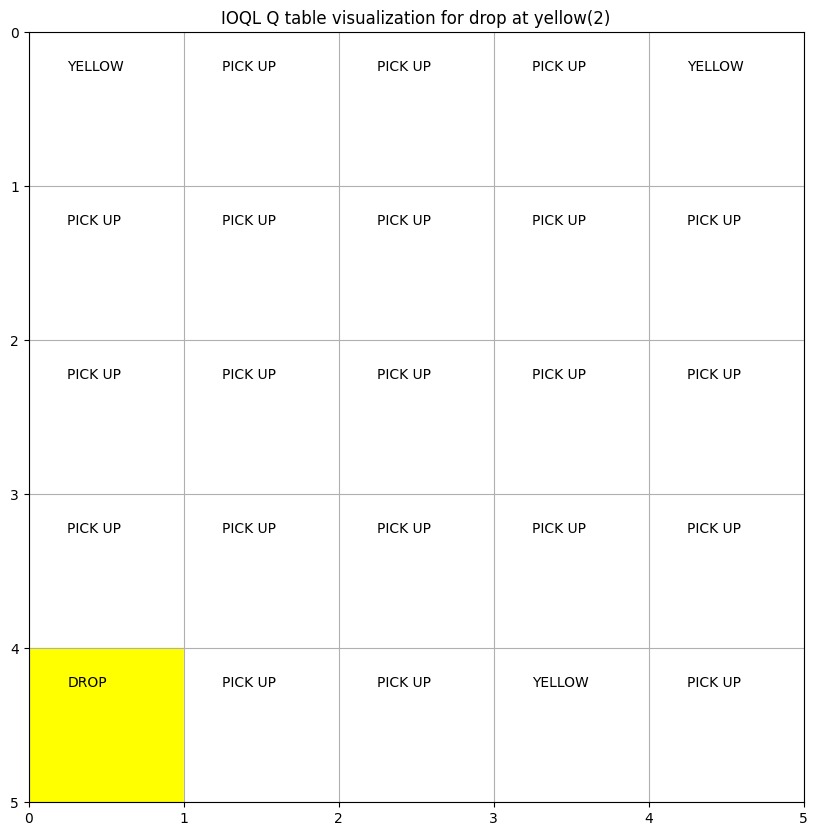

In [27]:
plot_Qoption(q_values_intra, env, 4, 2, 'IOQL Q table visualization for drop at yellow(2)')

# Experimenting with another set of Options

In [28]:
# Add parameters you might need here
gamma = 0.9
alpha = 0.1
episodes = 2000
num_runs = 5
initial_epsilon = 0.5
final_epsilon = 0.05
epsilon_decay = 0.995
reward_curves_SMDP_new = []
for _ in range(num_runs):
  q_values_SMDP_new = np.zeros((500,2))
  q_values_options_SMDP_new = np.zeros((2,4,5,5,6))


  reward_curve = []
  colourLocs = env.unwrapped.locs
  for episode in tqdm(range(episodes)):
      state_t = env.reset()
      done = False
      state = state_t[0]
      episode_reward = 0
      epsilon = max(final_epsilon, initial_epsilon * (epsilon_decay ** episode))
      while not done:
          # Choose action
          option = egreedy(q_values_SMDP_new, state, epsilon, q_values_SMDP_new.shape[1])
          reward_bar = 0
          state_t = state
          steps = 0
          optdone = False
          while (optdone == False and done == False):
              optact, optdone = pickordrop(option, env, state, q_values_options_SMDP_new[option], epsilon)
              if optdone:
                  continue
              next_state, reward, done, _, _ = env.step(optact)
              state_x, state_y, P, D = env.decode(state)
              next_state_x, next_state_y, _, _ = env.decode(next_state)
              if option:
                q_values_options_SMDP_new[option][D][state_x][state_y][optact] += alpha*(reward + gamma*np.max(q_values_options_SMDP_new[option][D][next_state_x][next_state_y]) - q_values_options_SMDP_new[option][D][state_x][state_y][optact])
              else:
                extra_reward = 0
                taxiPos = colourLocs.index((state_x, state_y)) if (state_x, state_y) in colourLocs else None
                if taxiPos == P and optact == 4:
                  extra_reward = 100
                q_values_options_SMDP_new[option][P][state_x][state_y][optact] += alpha*(reward + extra_reward + gamma*np.max(q_values_options_SMDP_new[option][P][next_state_x][next_state_y]) - q_values_options_SMDP_new[option][P][state_x][state_y][optact])
              reward_bar = gamma*reward_bar + reward
              state = next_state
              steps += 1

          q_values_SMDP_new[state_t, option] += alpha*(reward_bar + (gamma**steps)*np.max(q_values_SMDP_new[state,:]) - q_values_SMDP_new[state_t,option])
          episode_reward += reward_bar

      # Append the episode reward to the reward curve
      reward_curve.append(episode_reward)
  reward_curves_SMDP_new.append(reward_curve)


100%|██████████| 2000/2000 [00:07<00:00, 266.97it/s]


In [29]:
np.mean(reward_curves_SMDP_new[4])

7.070080023411834

In [30]:
max(reward_curves_SMDP_new[0])

15.904900000000001

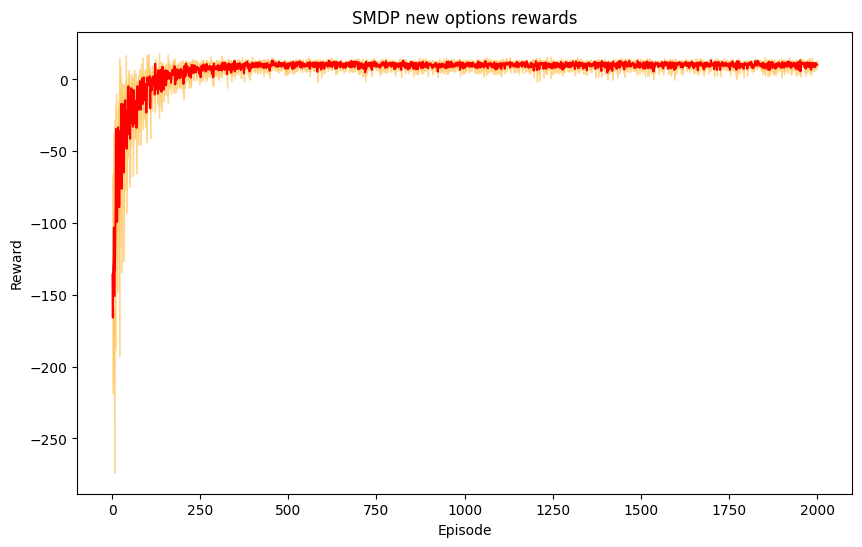

In [31]:
plot_rewards(reward_curves_SMDP_new, episodes, 'SMDP new options rewards')

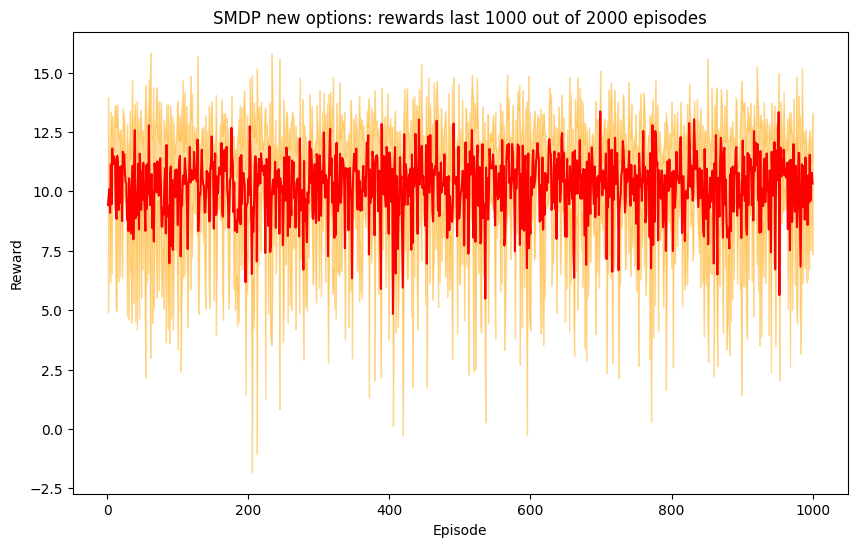

In [32]:
reward_curves_SMDP_new = np.asarray(reward_curves_SMDP_new)
plot_rewards(reward_curves_SMDP_new[:, -1000:], 1000, 'SMDP new options: rewards last 1000 out of 2000 episodes')

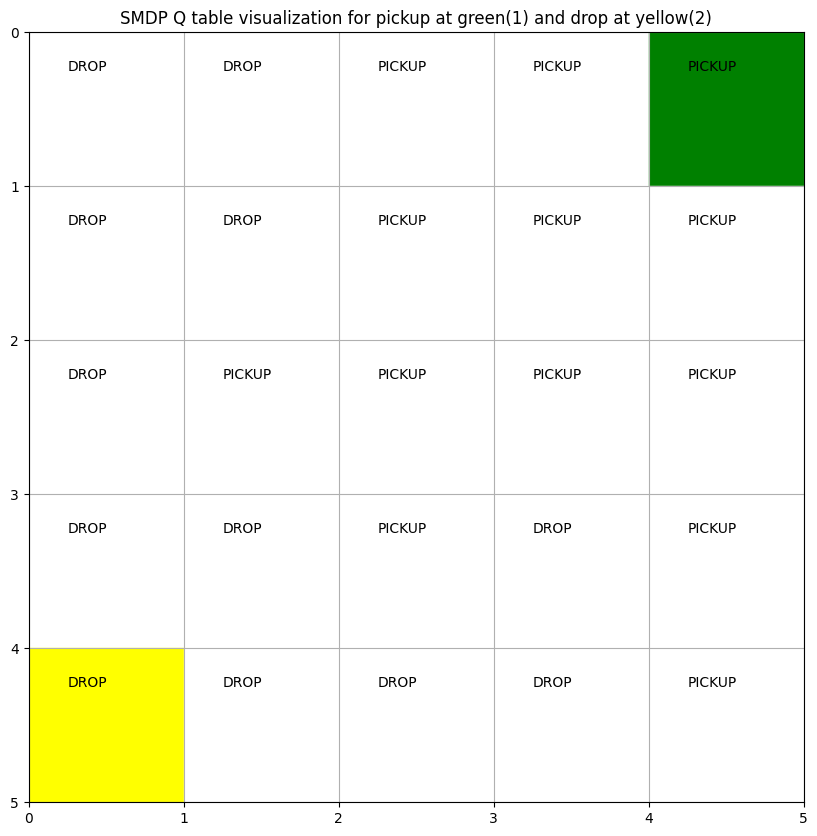

In [33]:
plot_Qoption_alt(q_values_SMDP_new, env, 1, 2, 'SMDP Q table visualization for pickup at green(1) and drop at yellow(2)')

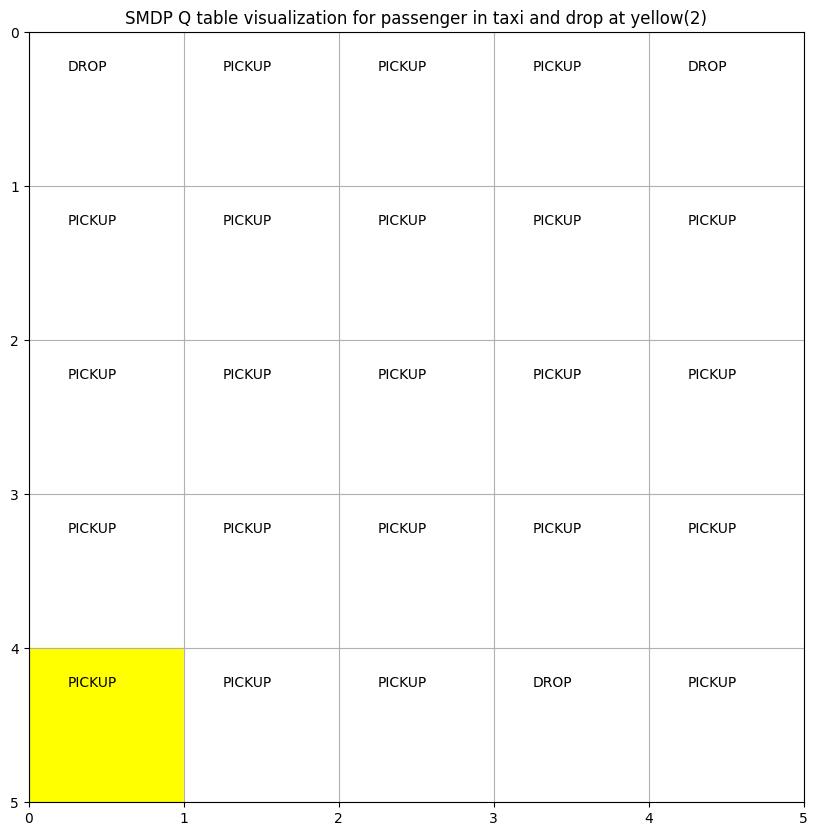

In [34]:
plot_Qoption_alt(q_values_SMDP_new, env, 4, 2, 'SMDP Q table visualization for passenger in taxi and drop at yellow(2)')

In [35]:
#### Intra-Option Q-Learning

def check_option(env, state, action, epsilon, q_values):
    valid_options = []
    for i in range(2):
      optact, _ = pickordrop(i, env, state, q_values[i], epsilon)
      if optact == action:
        valid_options = valid_options + [i]
    return valid_options

def terminate_option(env, state, option, epsilon, q_values):
    _, optdone = pickordrop(option, env, state, q_values[option],epsilon)
    return optdone



# Add parameters you might need here
gamma = 0.9
alpha = 0.1

episodes = 2000
num_runs = 5
initial_epsilon = 0.5
final_epsilon = 0.05
epsilon_decay = 0.995
reward_curves_intra_new = []
for _ in range(num_runs):
  reward_curve = []
  q_values_intra = np.zeros((500,2))
  q_values_options = np.zeros((2,4,5,5,6))

  # Iterate over 1000 episodes
  for episode in tqdm(range(episodes)):


    state_t = env.reset()
    done = False
    state = state_t[0]
    episode_reward = 0
    epsilon = max(final_epsilon, initial_epsilon * (epsilon_decay ** episode))
    while not done:
        # Choose action
        option = egreedy(q_values_intra, state, epsilon, q_values_intra.shape[1])
        reward_bar = 0
        state_t = state
        steps = 0
        optdone = False
        while (optdone == False and done == False):
            optact, optdone = pickordrop(option, env, state, q_values_options[option], epsilon)
            if optdone:
                continue
            next_state, reward, done, _, _ = env.step(optact)
            # if done:
            #     optdone = True
            #     continue
            state_x, state_y, P, D = env.decode(state)
            next_state_x, next_state_y, _, _ = env.decode(next_state)
            if option:
              q_values_options[option][D][state_x][state_y][optact] += alpha*(reward + gamma*np.max(q_values_options[option][D][next_state_x][next_state_y]) - q_values_options[option][D][state_x][state_y][optact])

            else:

              taxiPos = colourLocs.index((state_x, state_y)) if (state_x, state_y) in colourLocs else None
              extra_reward = 0
              if taxiPos == P and optact == 4:
                extra_reward = 10

              q_values_options[option][P][state_x][state_y][optact] += alpha*(reward+extra_reward + gamma*np.max(q_values_options[option][P][next_state_x][next_state_y]) - q_values_options[option][P][state_x][state_y][optact])

            reward_bar = gamma*reward_bar + reward
            state = next_state
            steps += 1


            matching_options = check_option(env, state, optact,epsilon,q_values_options)

            # One-step intra-option Q-Learning update for all options with the same action
            for o in matching_options:
                beta = terminate_option(env, state, o, epsilon,q_values_options)
                Q_tilde = (1-beta)*q_values_intra[next_state, o] + beta*(max(q_values_intra[next_state, :]))
                q_values_intra[next_state, o] += alpha*(reward + gamma*Q_tilde - q_values_intra[next_state,o])


        q_values_intra[state_t, option] += alpha*(reward_bar + (gamma**steps)*np.max(q_values_intra[state,:]) - q_values_intra[state_t,option])
        episode_reward += reward_bar

    # Append the episode reward to the reward curve
    reward_curve.append(episode_reward)

  reward_curves_intra_new.append(reward_curve)

100%|██████████| 2000/2000 [00:10<00:00, 191.50it/s]


In [36]:
np.mean(reward_curves_intra_new[0])

6.996491470855597

In [37]:
max(reward_curves_intra_new[0])

15.904900000000001

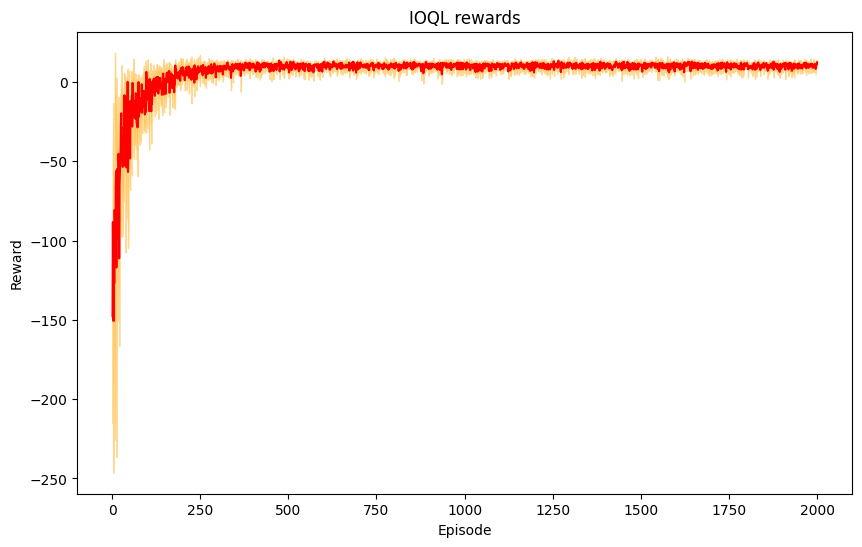

In [38]:
plot_rewards(reward_curves_intra_new, episodes, 'IOQL rewards')

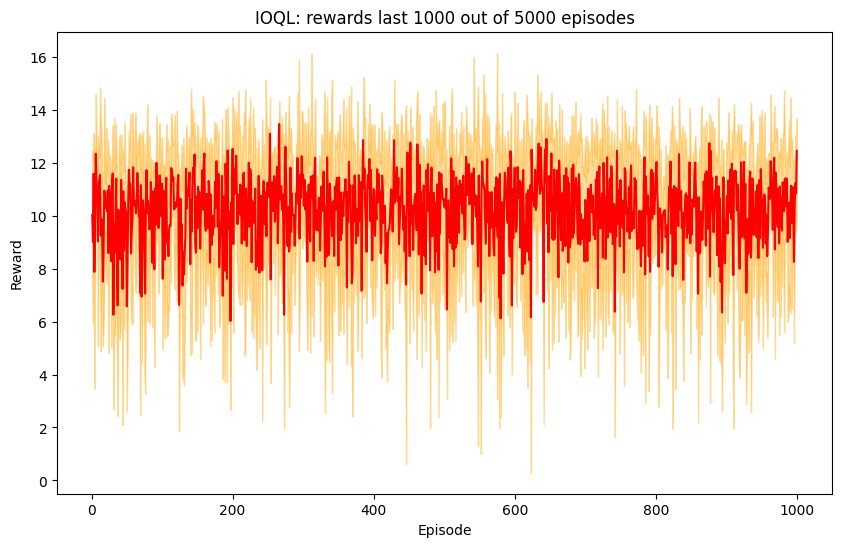

In [39]:
reward_curves_intra_new = np.asarray(reward_curves_intra_new)
plot_rewards(reward_curves_intra_new[:, -1000:], 1000, 'IOQL: rewards last 1000 out of 5000 episodes')

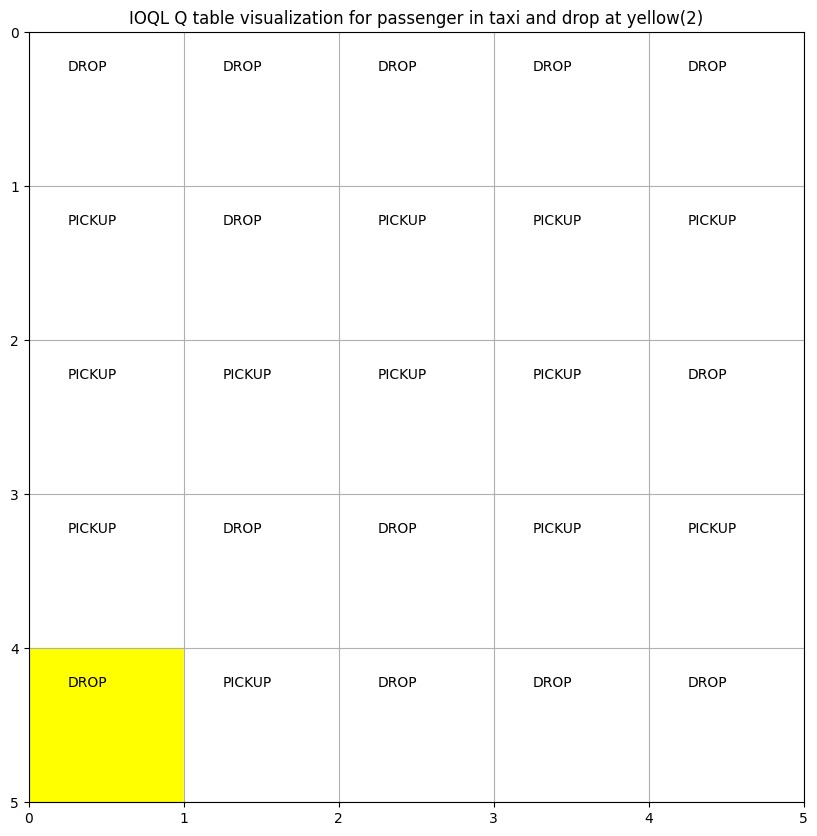

In [40]:
plot_Qoption_alt(q_values_intra, env, 4, 2, 'IOQL Q table visualization for passenger in taxi and drop at yellow(2)')

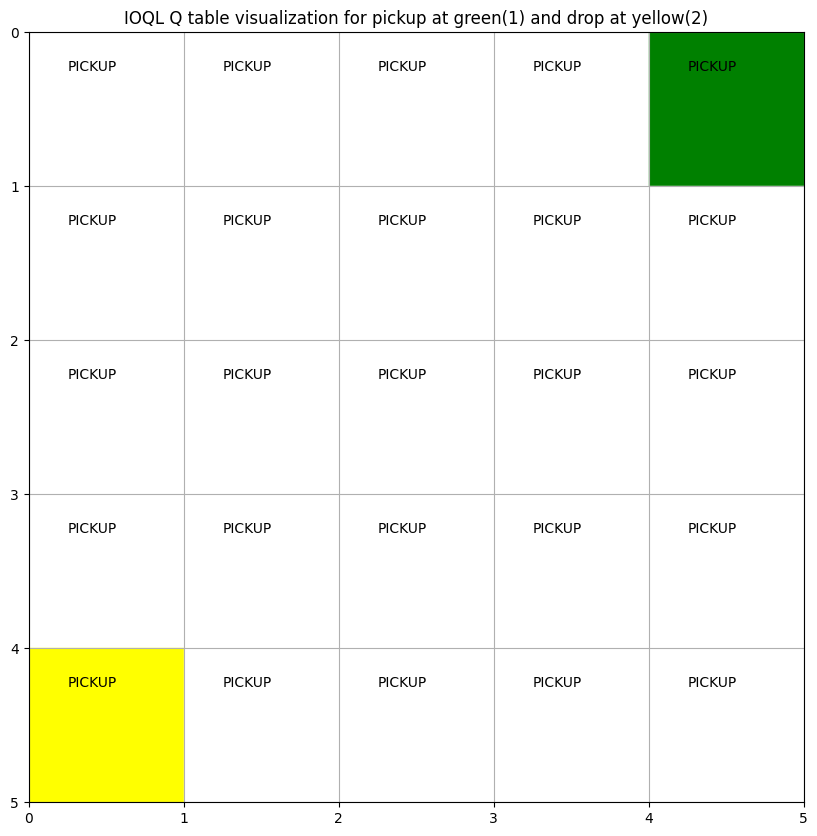

In [41]:
plot_Qoption_alt(q_values_intra, env, 1, 2, 'IOQL Q table visualization for pickup at green(1) and drop at yellow(2)')